In [39]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.image as img
import scipy.ndimage as spimg
import numpy as np
import os
import sys
from scipy import ndimage
from PIL import Image as PILim

%matplotlib inline

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':


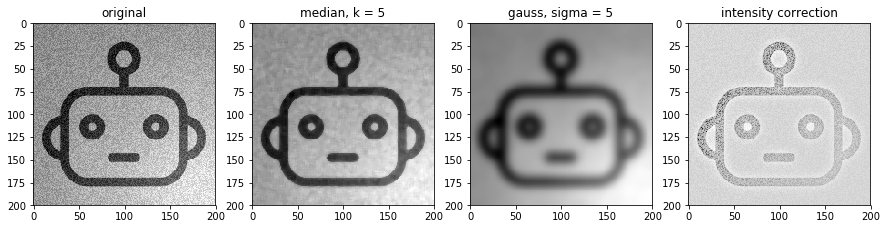

In [60]:
#Task 1 and 2: Filter noise and intesity correction
Im = img.imread(r'.\data2\Head\9.png')
fig = plt.figure(figsize=(15, 10))
# applying gauss filter
gauss = spimg.gaussian_filter(Im, sigma = 5)
# applying median filter
medi = spimg.median_filter(Im,size = 5)
# intesity correction
diff = np.log2(Im) - np.log2(gflt)
Maxi = np.max(Im-gauss)
Mini = np.min(Im-gauss)
corrected = (diff - Mini)*(Maxi-Mini)
plt.subplot(141)
plt.imshow(Im, cmap='gray')
plt.title('original')
plt.subplot(142)
plt.imshow(medi, cmap='gray')
plt.title('median, k = 5')
plt.subplot(143)
plt.imshow(gauss, cmap='gray')
plt.title('gauss, sigma = 5')
plt.subplot(144)
plt.imshow(corrected, cmap='gray')
plt.title('intensity correction')

In [35]:
#Read folders with dataset
folders = [
    r'.\\data2\\Arms\\',
    r'.\\data2\\Figure_normal_legs\\',
    r'.\\data2\\FigureWheels\\',
    r'.\\data2\\Head\\'
]
#Create folders for resized images
newpath = r'.\data2\Arms_r'
if not os.path.exists(newpath):
    os.makedirs(newpath)
newpath = r'.\data2\Figure_normal_legs_r'
if not os.path.exists(newpath):
    os.makedirs(newpath)
newpath = r'.\data2\FigureWheels_r'
if not os.path.exists(newpath):
    os.makedirs(newpath)
newpath = r'.\data2\Head_r'
if not os.path.exists(newpath):
    os.makedirs(newpath)
#Read new folders
folders2 = [
    r'.\\data2\\Arms_r\\',
    r'.\\data2\\Figure_normal_legs_r\\',
    r'.\\data2\\FigureWheels_r\\',
    r'.\\data2\\Head_r\\'
]
#Function for resizing images, after resizing image will be saved in new folder
def resize_im(folder,folder2):
  """Load the data for a single image, resize and save it in new folder"""
  image_files = os.listdir(folder)
  print(folder)
  for image in image_files:
    #Read path
    image_file = os.path.join(folder, image)
    image_file2 = os.path.join(folder2, image)
    #Open image with PIL Image model
    image_data = PILim.open(image_file)
    #Resize 200x200 image into 28x28 image
    image_data = image_data.resize((28,28),PILim.NEAREST)
    #Save resized image in other folder
    image_data.save(image_file2,quality=95) 
  return 
#Repeat function for all folders
for idx in range(len(folders)):
    folder = folders[idx]
    folder2 = folders2[idx]
    resize_im(folder,folder2)

.\\data2\\Arms\\
.\\data2\\Figure_normal_legs\\
.\\data2\\FigureWheels\\
.\\data2\\Head\\


In [36]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

#Function for reading images and putting them in dataset
def load_image(folder, min_num_images):
  """Load the data for a single image."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

X_datasets = list()
Y_datasets = list()
for idx in range(len(folders)):
    folder = folders2[idx] 
    X_datasets.append(load_image(folder, 200))
    labels = np.zeros((X_datasets[-1].shape[0],len(folders)))
    labels[:,idx] = 1
    Y_datasets.append(labels)

.\\data2\\Arms_r\\
Full dataset tensor: (784, 28, 28)
Mean: 0.112542
Standard deviation: 0.182116
.\\data2\\Figure_normal_legs_r\\
Full dataset tensor: (622, 28, 28)
Mean: 0.0883723
Standard deviation: 0.20202
.\\data2\\FigureWheels_r\\
Full dataset tensor: (222, 28, 28)
Mean: 0.075514
Standard deviation: 0.206567
.\\data2\\Head_r\\
Full dataset tensor: (473, 28, 28)
Mean: 0.0373297
Standard deviation: 0.226996


Total samples number: (2101, 28, 28)
Samples for tests: 526
Samples for trains: 1575


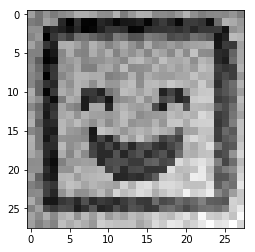

In [37]:
from sklearn.model_selection import train_test_split
#concatenate datasets and split them into train and tests samples
X_datasets2 = np.concatenate(X_datasets)
Y_datasets2 = np.concatenate(Y_datasets)
print("Total samples number:",X_datasets2.shape)
X_trains,X_tests,Y_trains,Y_tests = train_test_split(X_datasets2,Y_datasets2,test_size=0.25)
print("Samples for tests:",Y_tests.shape[0])
print("Samples for trains:",Y_trains.shape[0])
plt.imshow(X_tests[0],cmap='gray')

In [55]:
#Task 3: Neuron Network
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Reshape
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.optimizers import SGD
import numpy

#Callbacks to stop network when its stop improving
callbacks = [
    EarlyStopping(monitor='val_loss',patience = 2, min_delta=0.00001, verbose=1,mode='auto'),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(filepath='./weights.net',monitor ='val_loss', verbose=1, save_best_only=True),
    
]

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
#input vector
input_dim = X_trains[0].shape[0]*X_trains[0].shape[1]

# create model
model = Sequential()
#Reshape layer to reshape image into vector
model.add(Reshape((input_dim,), input_shape=(X_trains[0].shape[0],X_trains[0].shape[1])))
#Input layer
model.add(Dense(input_dim, input_shape = (input_dim,), init='uniform', activation='relu'))
#Hidden layer
model.add(Dense(int(input_dim/2), init='uniform', activation='relu'))
#Output layer
model.add(Dense(Y_trains[0].shape[0],init='uniform', name="output"))
model.add(Activation('softmax', name="softmax"))
model.summary()

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Fit the model
model.fit(X_trains, 
          Y_trains, 
          epochs=50, 
          batch_size=10, 
          verbose=2, 
          validation_split=0.25,
          callbacks=callbacks)
# calculate predictions
results = model.evaluate(X_tests, Y_tests, batch_size=32, verbose=1, sample_weight=None)
# round predictions
print( 'Accurasy is: ', 100*results[1])

(28, 28)
4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_6 (Dense)              (None, 392)               307720    
_________________________________________________________________
output (Dense)               (None, 4)                 1572      
_________________________________________________________________
softmax (Activation)         (None, 4)                 0         
Total params: 924,732
Trainable params: 924,732
Non-trainable params: 0
_________________________________________________________________


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(784, input_shape=(784,), activation="relu", kernel_initializer="uniform")`
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(392, activation="relu", kernel_initializer="uniform")`
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, name="output", kernel_initializer="uniform")`


Train on 1181 samples, validate on 394 samples
Epoch 1/50
Epoch 00001: val_loss improved from inf to 0.73563, saving model to ./weights.net
 - 4s - loss: 0.8584 - acc: 0.6672 - val_loss: 0.7356 - val_acc: 0.7056
Epoch 2/50
Epoch 00002: val_loss did not improve
 - 3s - loss: 0.4835 - acc: 0.8247 - val_loss: 0.7761 - val_acc: 0.7513
Epoch 3/50
Epoch 00003: val_loss did not improve
 - 3s - loss: 0.2666 - acc: 0.9111 - val_loss: 0.9994 - val_acc: 0.7259
Epoch 00003: early stopping
526/526 [==============================] - 0s 208us/step
Accurasy is:  76.2357413995
